## Calculating Dynamic topography

Set `ekey` below to plot different experiments.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import xarray as xr
import scipy as sp
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client, progress

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.24:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.24:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157`
* Then, make sure the following cell matches the scheduler address.

In [3]:
client = Client('tcp://10.0.64.12:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [4]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
mdt_1deg = sea_level.load() + 0.5  #NOTE: minor correction to MSL

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 14.6 s, sys: 8.83 s, total: 23.4 s
Wall time: 27.8 s


In [5]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
mdt_025deg = sea_level.load() + 0.5  #NOTE: minor correction to MSL

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 14.7 s, sys: 9.23 s, total: 23.9 s
Wall time: 40.1 s


In [6]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

sea_level = cc.get_nc_variable(expt,'ocean_daily.nc','eta_t',
                               n=n_files,time_units=time_units, offset=offset)\
                                 .sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
mdt_01deg = sea_level.load() + 0.5 #NOTE: minor correction to MSL

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 2min 9s, sys: 15.5 s, total: 2min 25s
Wall time: 34min 20s


In [7]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/mdt_cnes_cls2013_global.nc'
MDT = xr.open_dataset(aviso_file).mdt.mean('time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


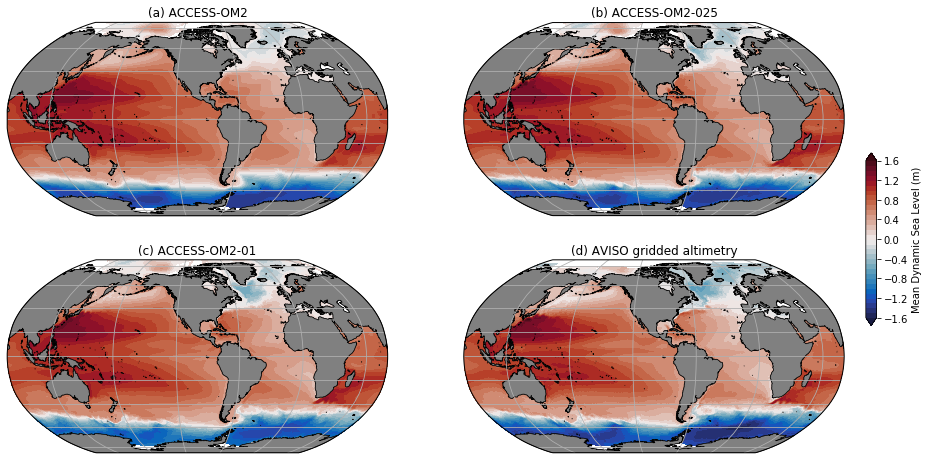

In [8]:
plt.figure(figsize=(15,8))
clev = np.arange(-1.6,1.601,0.1)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
    
ax = plt.subplot(2,2,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_1deg.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
plt.title('(a) ACCESS-OM2')

ax = plt.subplot(2,2,2,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_025deg.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
plt.title('(b) ACCESS-OM2-025')

ax = plt.subplot(2,2,3,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = mdt_01deg.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,
                                extend='both',transform=ccrs.PlateCarree())
plt.title('(c) ACCESS-OM2-01')

ax = plt.subplot(2,2,4,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = MDT.plot(cmap=cm.cm.balance,levels=clev,add_colorbar=False,
                        extend='both',transform=ccrs.PlateCarree())
plt.title('(d) AVISO gridded altimetry')

ax3 = plt.axes([0.92,0.35,0.01,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Mean Dynamic Sea Level (m)')
savefigure('mean_dynamic_topography')
